In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from numba import jit, njit, cuda, prange
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.signal as ss
import scipy.integrate as si
import scipy.optimize

import time

(400001, 100, 2)


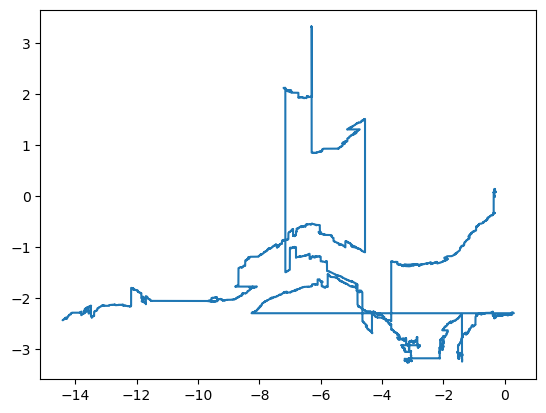

In [2]:
mctrajlist = []
for i in range(100):
    fname = '/pscratch/sd/h/hbhat512/mcsoldblwell/mctrigdblwell2d' + str(i+1) + '.dat'
    arr = np.fromfile(fname, dtype=np.float64).reshape((-1,2))
    mctrajlist.append(arr)

mctraj = np.stack(mctrajlist, 1)
# mctraj = mctraj[:101,:,:]
print(mctraj.shape)

plt.plot(mctraj[:,0,0],mctraj[:,0,1])
plt.show()

In [3]:
dilfac = 4000
mctraj = mctraj[::dilfac,:]
#plt.plot(mctraj)
#plt.show()
numtraj = mctraj.shape[1]
lentraj = mctraj.shape[0]
print(mctraj.shape)

(101, 100, 2)


In [4]:
# time step of the data
deltat = 0.0001*dilfac

# crucial parameter that sets internal time step
numsteps = dilfac
h = deltat/numsteps

# constant diffusion
g = 0.1

# levy alpha parameter
alpha = 1.0

# take L = 2
bigL = 2

# set n2, number of points to the left of the origin
n2 = 32
npts = 2*n2 + 1
nplot = npts
xplot = np.linspace(-2*np.pi, 2*np.pi, nplot+1)
xplot = xplot[:nplot]
xp1, xp2 = np.meshgrid(xplot, xplot)

# number of modes to keep track of in theta
# used bigJ = 4 for sin2d
bigJ = 4

# take n_L = 2
nL = 4
ds = 1.0/(bigL*nL)
uvec = np.arange(-n2,n2+1)*ds
umin = np.amin(uvec)
umax = np.amax(uvec)

U1, U2 = np.meshgrid(uvec, uvec)

print([ds, umin, umax])

# first axis in newpsi and oldpsi refers to the batching dimension
batchsize = 20
numbatches = (lentraj-1)//batchsize
print(numbatches)
print(lentraj-1)
print(numbatches*batchsize)

[0.125, -4.0, 4.0]
5
100
100


In [5]:
# now construct f on a plotting grid
@njit
def represent(theta, JJ):
    f1 = np.zeros((nplot, nplot), dtype=np.complex128)
    f2 = np.zeros((nplot, nplot), dtype=np.complex128)    
    modes = np.arange(-JJ,JJ+1)/bigL
    for j1 in range(2*JJ+1):
        for j2 in range(2*JJ+1):
            f1 += theta[j1, j2, 0]*np.exp(1j*(xp1*modes[j1] + xp2*modes[j2]))
            f2 += theta[j1, j2, 1]*np.exp(1j*(xp1*modes[j1] + xp2*modes[j2]))
    
    return f1, f2

# now construct f on a plotting grid
# low-dimensional version
@njit
def LDrepresent(theta, JJ):
    f1 = np.zeros((nplot, nplot), dtype=np.complex128)
    f2 = np.zeros((nplot, nplot), dtype=np.complex128)
    modes = np.arange(-JJ,JJ+1)/bigL
    for j2 in range(2*JJ+1):
        f1 += theta[JJ, j2, 0]*np.exp(1j*(xp1*modes[JJ] + xp2*modes[j2]))
    
    for j1 in range(2*JJ+1):
        f2 += theta[j1, JJ, 1]*np.exp(1j*(xp1*modes[j1] + xp2*modes[JJ]))
    
    return f1, f2

In [6]:
truetheta = np.zeros((2*bigJ+1, 2*bigJ+1, 2), dtype=np.complex128)

for j in range(-bigJ, bigJ+1):
    if j == -2:
        truetheta[bigJ, bigJ + j, 0] = 0.5j
    if j == 2:
        truetheta[bigJ, bigJ + j, 0] = -0.5j

# for j in range(-bigJ, bigJ+1):
#     if j == -2:
#         truetheta[bigJ + j, bigJ, 1] = -0.5j
#     if j == 2:
#         truetheta[bigJ + j, bigJ, 1] = 0.5j

for j in range(-bigJ, bigJ+1):
    if j == -2:
        truetheta[bigJ + j, bigJ, 1] = 7j/40
    if j == 2:
        truetheta[bigJ + j, bigJ, 1] = -7j/40
    if j == -4:
        truetheta[bigJ + j, bigJ, 1] = 1j/80
    if j == 4:
        truetheta[bigJ + j, bigJ, 1] = -1j/80

# Fourier representation of f_1(x1,x2) = x2
# for j in range(-bigJ, bigJ+1):
#     if j != 0:
#         truetheta[bigJ, bigJ + j, 0] = 4j*(-1)**j / (j*bigL)

# V(x) = (x**2 - 4)**2 / 10
# Fourier representation of f_2(x1,x2) = -V'(x1)
# for j in range(-bigJ, bigJ+1):
#     if j != 0:
#         truetheta[bigJ + j, bigJ, 1] = -(32*1j*(-1)**j*(-6 + j**2*(-1 + np.pi**2)))/(5*(j**3)*bigL)

f1, f2 = LDrepresent(truetheta, bigJ)
dx = xplot[1] - xplot[0]
truef1 = np.sin(xp2)
print(np.sum(np.square(np.abs(f1 - truef1))) * dx**2)
truef2 = 0.05*(7 + np.cos(xp1))*np.sin(xp1)
# truef2 = -np.sin(xp1)
print(np.sum(np.square(np.abs(f2 - truef2))) * dx**2)

0.0
3.1465569626389376e-31


In [7]:
@njit(parallel=True)
def empiricalcharfun(mc):
    psi = np.zeros((lentraj,npts,npts), dtype=np.complex128)
    for kk in prange(lentraj):
        for ii in prange(npts):
            for jj in prange(npts):
                psi[kk,ii,jj] = np.mean(np.exp(1j*(uvec[ii]*mc[kk,:,0]+uvec[jj]*mc[kk,:,1])))
    return psi


In [8]:
psiall = empiricalcharfun(mctraj)
print(psiall.shape)

# initial char fun
psi0 = psiall[:-1,:,:]

# target char fun
psitarget = psiall[1:,:,:]

# need this guy to propagate
diagfac = np.exp(-h*np.abs((U1 + U2)*g)**alpha)
print(diagfac.shape)

ddiagfac = cuda.to_device(diagfac)

(101, 65, 65)
(65, 65)


In [9]:
@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:])')
def update(newpsi, oldpsi, dtheta, dtheta2, ddiagfac):
    m, j1, j2 = cuda.grid(3)
    if m < batchsize and j1 < npts and j2 < npts:
        term11 = 0.0
        term12 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        for jp1 in range(2*bigJ+1):
            for jp2 in range(2*bigJ+1):
                if abs(truej1 + (jp1-bigJ)*nL) <= n2 and abs(truej2 + (jp2-bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (jp1-bigJ)*nL, j2 + (jp2-bigJ)*nL]
                    term11 += dtheta[jp1, jp2, 0]*tmp
                    term12 += dtheta[jp1, jp2, 1]*tmp
                    
        term211 = 0.0
        term212 = 0.0
        term221 = 0.0
        term222 = 0.0
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                if abs(truej1 + (k1-2*bigJ)*nL) <= n2 and abs(truej2 + (k2-2*bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (k1-2*bigJ)*nL, j2 + (k2-2*bigJ)*nL]
                    term211 += dtheta2[k1, k2, 0, 0]*tmp
                    term212 += dtheta2[k1, k2, 0, 1]*tmp
                    term221 += dtheta2[k1, k2, 1, 0]*tmp
                    term222 += dtheta2[k1, k2, 1, 1]*tmp
        newpsi[m, j1, j2] += 1j*(h*ds)*(truej1*term11 + truej2*term12)
        newpsi[m, j1, j2] += -0.5*((h*ds)**2)*(term211*truej1**2 + (term212+term221)*truej1*truej2 + term222*truej2**2)
        newpsi[m, j1, j2] *= ddiagfac[j1, j2] # math.exp(-h*ds*g*abs(truej1+truej2)**alpha)

In [10]:
@cuda.jit
def copyover(newpsi, oldpsi):
    m, i, j = cuda.grid(3)
    if m < batchsize and i < npts and j < npts:
        oldpsi[m,i,j] = newpsi[m,i,j]

In [11]:
def MMDlossGPU(theta):
    theta2 = np.zeros((4*bigJ+1, 4*bigJ+1, 2, 2), dtype=np.complex128)
    for i in range(2):
        for j in range(2):
            theta2[:,:,i,j] = ss.convolve(theta[:,:,i], theta[:,:,j])
    
    dtheta = cuda.to_device(theta)
    dtheta2 = cuda.to_device(theta2)
    
    threadsperblock = (8,8,8) # try 8, 10, 10
    blockspergrid_x = int(np.ceil(batchsize / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(npts / threadsperblock[1]))
    blockspergrid_z = int(np.ceil(npts / threadsperblock[2]))
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    loss = 0.0
    for batch in range(numbatches):
        thisbatch = np.arange(batch*batchsize, (batch+1)*batchsize, dtype=np.int32)
        doldpsi = cuda.to_device(psi0[thisbatch,:,:])
        dnewpsi = cuda.to_device(psi0[thisbatch,:,:])
        for k in range(numsteps):
            update[blockspergrid, threadsperblock](dnewpsi, doldpsi, dtheta, dtheta2, ddiagfac)
            copyover[blockspergrid, threadsperblock](dnewpsi, doldpsi)
        psifinal = dnewpsi.copy_to_host() 
        loss += 0.5*np.sum(np.square(np.abs(psifinal - psitarget[thisbatch,:,:])))
    
    return loss/(lentraj-1)

In [12]:
test = MMDlossGPU(truetheta)
print(test)

8.97767423678729


In [13]:
# def trialtheta(p1, p2):
#     theta = np.zeros((2*bigJ+1, 2*bigJ+1, 2), dtype=np.complex128)

#     for j in range(-bigJ, bigJ+1):
#         if j == -2:
#             theta[bigJ, bigJ + j, 0] = -p1*1j
#         if j == 2:
#             theta[bigJ, bigJ + j, 0] = p1*1j

#     for j in range(-bigJ, bigJ+1):
#         if j == -2:
#             theta[bigJ + j, bigJ, 1] = -p2*1j
#         if j == 2:
#             theta[bigJ + j, bigJ, 1] = p2*1j
    
#     return theta

In [14]:
# nn = 20
# p1vec = np.linspace(-2,2,nn)
# p2vec = np.linspace(-2,2,nn)
# lossarray = np.zeros((nn, nn))
# for p1ind in range(nn):
#     for p2ind in range(nn):
#         print(p1ind, p2ind)
#         lossarray[p1ind,p2ind] = MMDlossGPU(trialtheta(p1vec[p1ind], p2vec[p2ind]))

In [15]:
# plt.contour(p1vec, p2vec, lossarray,levels=20)
# plt.show()

In [16]:
# lossarray

In [17]:
@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:])')
def updatev2(newpsi, oldpsi, dtheta, dtheta2, ddiagfac):
    m, j1, j2 = cuda.grid(3)
    if m < batchsize and j1 < npts and j2 < npts:
        term11 = 0.0
        term12 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        for jp1 in range(2*bigJ+1):
            for jp2 in range(2*bigJ+1):
                if abs(truej1 + (jp1-bigJ)*nL) <= n2 and abs(truej2 + (jp2-bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (jp1-bigJ)*nL, j2 + (jp2-bigJ)*nL]
                    term11 += dtheta[jp1, jp2, 0]*tmp
                    term12 += dtheta[jp1, jp2, 1]*tmp
                    
        term211 = 0.0
        term212 = 0.0
        term221 = 0.0
        term222 = 0.0
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                if abs(truej1 + (k1-2*bigJ)*nL) <= n2 and abs(truej2 + (k2-2*bigJ)*nL) <= n2:
                    tmp = oldpsi[m, j1 + (k1-2*bigJ)*nL, j2 + (k2-2*bigJ)*nL]
                    term211 += dtheta2[k1, k2, 0, 0]*tmp
                    term212 += dtheta2[k1, k2, 0, 1]*tmp
                    term221 += dtheta2[k1, k2, 1, 0]*tmp
                    term222 += dtheta2[k1, k2, 1, 1]*tmp
        newpsi[m, j1, j2] = oldpsi[m, j1, j2]
        newpsi[m, j1, j2] += 1j*(h*ds)*(truej1*term11 + truej2*term12)
        newpsi[m, j1, j2] += -0.5*((h*ds)**2)*(term211*truej1**2 + (term212+term221)*truej1*truej2 + term222*truej2**2)
        newpsi[m, j1, j2] *= ddiagfac[j1, j2] # math.exp(-h*ds*g*abs(truej1+truej2)**alpha)

In [18]:
# @cuda.jit('void(complex128[:,:,:,:,:,:], complex128[:,:,:], complex128[:,:,:], float64[:,:])')
# def derivupdate(psi1, psi0, theta, diagfac):
#     m, j1, j2 = cuda.grid(3)
#     if m < batchsize and j1 < npts and j2 < npts:
#         truej1 = j1 - n2
#         truej2 = j2 - n2
#         for r1 in range(2*bigJ+1):
#             for r2 in range(2*bigJ+1):
#                 psi1[m,j1,j2,r1,r2,0] = 0.0
#                 psi1[m,j1,j2,r1,r2,1] = 0.0
#                 truer1 = r1 - bigJ
#                 truer2 = r2 - bigJ
#                 if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
#                     tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
#                     psi1[m,j1,j2,r1,r2,0] += 1j*(h*ds)*(j1-n2)*diagfac[j1,j2]*tmp
#                     psi1[m,j1,j2,r1,r2,1] += 1j*(h*ds)*(j2-n2)*diagfac[j1,j2]*tmp

#                 for k1 in range(4*bigJ+1):
#                     for k2 in range(4*bigJ+1):
#                         truek1 = k1 - 2*bigJ
#                         truek2 = k2 - 2*bigJ
#                         if abs(truek1-truer1)<=bigJ and abs(truek2-truer2)<=bigJ:
#                             if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
#                                 tmp = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
#                                 term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
#                                 term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
#                                 psi1[m,j1,j2,r1,r2,0] += -((h*ds)**2)*(j1-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
#                                 psi1[m,j1,j2,r1,r2,1] += -((h*ds)**2)*(j2-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2] 


In [19]:
# @njit(parallel=True)
# def CPUderivreduce3(lamb0, psi0, theta, diagfac, r1, r2):
#     psi1 = np.zeros((2,batchsize*numsteps,npts,npts), dtype=np.complex128)
#     for m in prange(batchsize*numsteps):
#         for j1 in prange(npts):
#             for j2 in prange(npts):
#                 truej1 = j1 - n2
#                 truej2 = j2 - n2
#                 lambval = lamb0[m, j1, j2]
#                 lambvalconj = lambval.real - 1j*lambval.imag
#                 truer1 = r1 - bigJ
#                 truer2 = r2 - bigJ
#                 if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
#                     tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
#                     psi1[0,m,j1,j2] += lambvalconj*1j*(h*ds)*(j1-n2)*diagfac[j1,j2]*tmp
#                     psi1[1,m,j1,j2] += lambvalconj*1j*(h*ds)*(j2-n2)*diagfac[j1,j2]*tmp

#                 for k1 in range(4*bigJ+1):
#                     for k2 in range(4*bigJ+1):
#                         truek1 = k1 - 2*bigJ
#                         truek2 = k2 - 2*bigJ
#                         if abs(truek1-truer1) <= bigJ and abs(truek2-truer2) <= bigJ:
#                             if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
#                                 tmp = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
#                                 term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
#                                 term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
#                                 psi1[0,m,j1,j2] += -lambvalconj*((h*ds)**2)*(j1-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
#                                 psi1[1,m,j1,j2] += -lambvalconj*((h*ds)**2)*(j2-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
#     return psi1


@cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], float64[:,:], int32, int32)')
def derivreduce3(psi1, lamb0conj, psi0, theta, diagfac, r1, r2):
    m, j1, j2 = cuda.grid(3)
    if m < batchsize*numsteps and j1 < npts and j2 < npts:
        out0 = 0.0
        out1 = 0.0
        truej1 = j1 - n2
        truej2 = j2 - n2
        lambvalconj = lamb0conj[m, j1, j2]
        truer1 = r1 - bigJ
        truer2 = r2 - bigJ
        if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
            tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
            overall = lambvalconj*1j*(h*ds)*diagfac[j1,j2]*tmp
            out0 += overall*truej1
            out1 += overall*truej2

        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                truek1 = k1 - 2*bigJ
                truek2 = k2 - 2*bigJ
                if abs(truek1-truer1) <= bigJ and abs(truek2-truer2) <= bigJ:
                    if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
                        tmp2 = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
                        term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
                        term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
                        overall2 = -lambvalconj*((h*ds)**2)*(term21 * truej1 + term22 * truej2)*tmp2*diagfac[j1,j2]
                        out0 += overall2*truej1
                        out1 += overall2*truej2
        
        psi1[0,m,j1,j2] = out0
        psi1[1,m,j1,j2] = out1

In [20]:
# @cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], float64[:,:], int32, int32)')
# def derivreduce2(psi1, lamb0, psi0, theta, diagfac, j1, j2):
#     m, r1, r2 = cuda.grid(3)
#     if m < batchsize and r1 < (2*bigJ+1) and r2 < (2*bigJ+1):
#         truer1 = r1 - bigJ
#         truer2 = r2 - bigJ
#         lambval = lamb0[m, j1, j2]
#         lambvalconj = lambval.real - 1j*lambval.imag
#         truej1 = j1 - n2
#         truej2 = j2 - n2
#         if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
#             tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
#             psi1[m,r1,r2,0] += lambvalconj*1j*(h*ds)*(j1-n2)*diagfac[j1,j2]*tmp
#             psi1[m,r1,r2,1] += lambvalconj*1j*(h*ds)*(j2-n2)*diagfac[j1,j2]*tmp

#         for k1 in range(4*bigJ+1):
#             for k2 in range(4*bigJ+1):
#                 truek1 = k1 - 2*bigJ
#                 truek2 = k2 - 2*bigJ
#                 if abs(truek1-truer1) <= bigJ and abs(truek2-truer2) <= bigJ:
#                     if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
#                         tmp = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
#                         term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
#                         term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
#                         psi1[m,r1,r2,0] += -lambvalconj*((h*ds)**2)*(j1-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
#                         psi1[m,r1,r2,1] += -lambvalconj*((h*ds)**2)*(j2-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2] 


In [21]:
# @cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], float64[:,:])')
# def derivreduce(psi1, lamb0, psi0, theta, diagfac):
#     m, r1, r2 = cuda.grid(3)
#     if m < batchsize and r1 < (2*bigJ+1) and r2 < (2*bigJ+1):
#         truer1 = r1 - bigJ
#         truer2 = r2 - bigJ
#         psi1[m,r1,r2,0] = 0.0
#         psi1[m,r1,r2,1] = 0.0
#         for j1 in range(npts):
#             for j2 in range(npts):
#                 lambval = lamb0[m, j1, j2]
#                 lambvalconj = lambval.real - 1j*lambval.imag
#                 truej1 = j1 - n2
#                 truej2 = j2 - n2
#                 if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
#                     tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
#                     psi1[m,r1,r2,0] += lambvalconj*1j*(h*ds)*(j1-n2)*diagfac[j1,j2]*tmp
#                     psi1[m,r1,r2,1] += lambvalconj*1j*(h*ds)*(j2-n2)*diagfac[j1,j2]*tmp

#                 for k1 in range(4*bigJ+1):
#                     for k2 in range(4*bigJ+1):
#                         truek1 = k1 - 2*bigJ
#                         truek2 = k2 - 2*bigJ
#                         if abs(truek1-truer1) <= bigJ and abs(truek2-truer2) <= bigJ:
#                             if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
#                                 tmp = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
#                                 term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
#                                 term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
#                                 psi1[m,r1,r2,0] += -lambvalconj*((h*ds)**2)*(j1-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
#                                 psi1[m,r1,r2,1] += -lambvalconj*((h*ds)**2)*(j2-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2] 


In [22]:
# let us assume that oldlamb is of size (npts, npts)
# we need to compute newlamb of the same size

@cuda.jit('void(complex128[:,:,:], complex128[:,:,:], complex128[:,:,:], complex128[:,:,:,:], float64[:,:])')
def GPUlambda(newlamb, oldlamb, theta, theta2, diagfac):
    m, l1, l2 = cuda.grid(3)
    if m < batchsize and l1 < npts and l2 < npts:
        newlamb[m,l1,l2] = oldlamb[m,l1,l2]*diagfac[l1,l2]
        truel1 = l1 - n2
        truel2 = l2 - n2
        for k1 in range(2*bigJ+1):
            for k2 in range(2*bigJ+1):
                truek1 = k1 - bigJ
                truek2 = k2 - bigJ
                ind1 = truel1 - truek1*nL
                ind2 = truel2 - truek2*nL
                if abs(ind1)<=n2 and abs(ind2)<=n2:
                    dd = diagfac[ind1+n2,ind2+n2]
                    newlamb[m,l1,l2] += dd*1j*(h*ds)*oldlamb[m,ind1+n2,ind2+n2]*(ind1*theta[k1,k2,0]+ind2*theta[k1,k2,1])
        for k1 in range(4*bigJ+1):
            for k2 in range(4*bigJ+1):
                truek1 = k1 - 2*bigJ
                truek2 = k2 - 2*bigJ
                ind1 = truel1 - truek1*nL
                ind2 = truel2 - truek2*nL
                if abs(ind1)<=n2 and abs(ind2)<=n2:
                    term211 = theta2[k1, k2, 0, 0]
                    term212 = theta2[k1, k2, 0, 1]
                    term221 = theta2[k1, k2, 1, 0]
                    term222 = theta2[k1, k2, 1, 1]
                    dd = diagfac[ind1+n2,ind2+n2]
                    newlamb[m,l1,l2] -= dd*0.5*(h*ds)**2*oldlamb[m,ind1+n2,ind2+n2]*(term211*ind1**2 + (term212+term221)*ind1*ind2 + term222*ind2**2)


In [23]:
@njit(parallel=True)
def derivupdate(theta, psi0):
    psi1 = np.zeros((batchsize,npts,npts,2*bigJ+1,2*bigJ+1,2), dtype=np.complex128)
    for m in prange(batchsize):
        for j1 in prange(npts):
            for j2 in prange(npts):
                j = np.array([j1,j2])
                truej1 = j1 - n2
                truej2 = j2 - n2
                for r1 in range(2*bigJ+1):
                    for r2 in range(2*bigJ+1):
                        truer1 = r1 - bigJ
                        truer2 = r2 - bigJ
                        if abs(truej1 + truer1*nL) <= n2 and abs(truej2 + truer2*nL) <= n2:
                            tmp = psi0[m, j1 + truer1*nL, j2 + truer2*nL]
                            psi1[m,j1,j2,r1,r2,:] += 1j*(h*ds)*(j-n2)*diagfac[j1,j2]*tmp

                        for k1 in range(4*bigJ+1):
                            for k2 in range(4*bigJ+1):
                                truek1 = k1 - 2*bigJ
                                truek2 = k2 - 2*bigJ
                                if abs(truek1-truer1)<=bigJ and abs(truek2-truer2)<=bigJ:
                                    if abs(truej1 + truek1*nL) <= n2 and abs(truej2 + truek2*nL) <= n2:
                                        tmp = psi0[m, j1 + truek1*nL, j2 + truek2*nL]
                                        term21 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,0]
                                        term22 = theta[truek1-truer1+bigJ,truek2-truer2+bigJ,1]
                                        psi1[m,j1,j2,r1,r2,:] += -((h*ds)**2)*(j-n2)*(term21 * truej1 + term22 * truej2)*tmp*diagfac[j1,j2]
    return psi1
    

In [24]:
# need to minibatch this!
# can handle only a certain number of steps at once

# adjoint method
def MMDadjGPU(theta):
    theta2 = np.zeros((4*bigJ+1, 4*bigJ+1, 2, 2), dtype=np.complex128)
    for i in range(2):
        for j in range(2):
            theta2[:,:,i,j] = ss.convolve(theta[:,:,i], theta[:,:,j])
    
    dtheta = cuda.to_device(theta)
    dtheta2 = cuda.to_device(theta2)

    threadsperblock = (4,4,4)
    blockspergrid_x = int(np.ceil(batchsize / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(npts / threadsperblock[1]))
    blockspergrid_z = int(np.ceil(npts / threadsperblock[2]))
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    # do the entire trajectory sequentially
    loss = 0.0
    derivmat = np.zeros((2*bigJ+1,2*bigJ+1,2), dtype=np.complex128)   
    ddu = cuda.to_device(np.zeros((batchsize, npts, npts, 2*bigJ+1, 2*bigJ+1, 2), dtype=np.complex128))
    for batch in range(numbatches):
        thisbatch = np.arange(batch*batchsize, (batch+1)*batchsize, dtype=np.int32)
        psimat = np.zeros((numsteps+1, batchsize, npts, npts), dtype=np.complex128)
        psimat[0,:,:,:] = psi0[thisbatch,:,:]
        dpsimat = cuda.to_device(psimat)
        
        for k in range(numsteps):
            updatev2[blockspergrid, threadsperblock](dpsimat[k+1,:,:,:], dpsimat[k,:,:,:], dtheta, dtheta2, ddiagfac)
        
        resid = dpsimat[-1,:,:,:].copy_to_host() - psitarget[thisbatch,:,:]
        loss += 0.5*np.sum(np.square(np.abs(resid)))/(lentraj-1)
        
        # everybody
        lambmat = np.zeros((numsteps+1, batchsize, npts, npts), dtype=np.complex128)
        lambmat[numsteps,:,:,:] = resid
        dlambmat = cuda.to_device(lambmat)
        
        for j in range(numsteps,0,-1):
            GPUlambda[blockspergrid, threadsperblock](dlambmat[j-1,:,:,:], dlambmat[j,:,:,:], dtheta, dtheta2, ddiagfac)

        # now form the derivative
        lambmatconj = dlambmat.copy_to_host().conj()
        for j in range(numsteps):
            du = derivupdate(theta, dpsimat[j,:,:,:].copy_to_host())
            derivmat += np.einsum('mab,mabijk->ijk',lambmatconj[j+1,:,:,:],du)/(lentraj-1)
        
    return loss, derivmat

In [25]:
# # therealdu = np.zeros((2*bigJ+1, 2*bigJ+1, 2), dtype=np.complex128)
# # ddu = cuda.to_device(np.zeros((batchsize*numsteps, npts, npts), dtype=np.complex128))
# # lambtest = np.random.normal(size=batchsize*npts*npts) + 1j*np.random.normal(size=batchsize*npts*npts)
# # dlambtest = cuda.to_device(lambtest.reshape((batchsize, npts, npts)))
# # psitest = np.random.normal(size=batchsize*npts*npts) + 1j*np.random.normal(size=batchsize*npts*npts)
# # dpsitest = cuda.to_device(psitest.reshape((batchsize, npts, npts)))
# thetatest = np.random.normal(size=2*(2*bigJ+1)**2) + 1j*np.random.normal(size=2*(2*bigJ+1)**2)
# thetatest = thetatest.reshape((2*bigJ+1, 2*bigJ+1, 2))
# dthetatest = cuda.to_device(thetatest)

In [26]:
# Dthreadsperblock = (16,4,4)
# Dblockspergrid_x = int(np.ceil(batchsize / Dthreadsperblock[0]))
# Dblockspergrid_y = int(np.ceil(npts / Dthreadsperblock[1]))
# Dblockspergrid_z = int(np.ceil(npts / Dthreadsperblock[2]))
# Dblockspergrid = (Dblockspergrid_x, Dblockspergrid_y, Dblockspergrid_z)


In [27]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

In [28]:
@cuda.jit('void(complex128[:,:,:,:], complex128[:,:,:], int32)')
def myassign(outarr, inarr, ind):
    m, j1, j2 = cuda.grid(3)
    if m < batchsize and j1 < npts and j2 < npts:
        outarr[ind,m,j1,j2] = inarr[m,j1,j2]


In [29]:
# start = time.time()
# for r1 in range(2*bigJ+1):
#     for r2 in range(2*bigJ+1):
#         for q in range(2):
#             derivreduce3[Dblockspergrid, Dthreadsperblock](ddu, dlambtest, dpsitest, dthetatest, ddiagfac, r1, r2, q)
#             mysum = sum_reduce(ddu.ravel())
#             therealdu[r1, r2, q] += mysum
# end = time.time()
# print(end-start)

In [30]:
# need to minibatch this!
# can handle only a certain number of steps at once

# adjoint method
def MMDadjGPUv2(theta):
    theta2 = np.zeros((4*bigJ+1, 4*bigJ+1, 2, 2), dtype=np.complex128)
    for i in range(2):
        for j in range(2):
            theta2[:,:,i,j] = ss.convolve(theta[:,:,i], theta[:,:,j])
    
    dtheta = cuda.to_device(theta)
    dtheta2 = cuda.to_device(theta2)
    
    threadsperblock = (8,8,8)
    blockspergrid_x = int(np.ceil(batchsize / threadsperblock[0]))
    blockspergrid_y = int(np.ceil(npts / threadsperblock[1]))
    blockspergrid_z = int(np.ceil(npts / threadsperblock[2]))
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    
    Dthreadsperblock = (8,8,8)
    Dblockspergrid_x = int(np.ceil(batchsize*numsteps / Dthreadsperblock[0]))
    Dblockspergrid_y = int(np.ceil(npts / Dthreadsperblock[1]))
    Dblockspergrid_z = int(np.ceil(npts / Dthreadsperblock[2]))
    Dblockspergrid = (Dblockspergrid_x, Dblockspergrid_y, Dblockspergrid_z)
    
    # do the entire trajectory sequentially
    loss = 0.0
    derivmat = np.zeros((2*bigJ+1,2*bigJ+1,2), dtype=np.complex128)
    ddu = cuda.to_device(np.zeros((2,batchsize*numsteps, npts, npts), dtype=np.complex128))
    for batch in range(numbatches):
        thisbatch = np.arange(batch*batchsize, (batch+1)*batchsize, dtype=np.int32)
        psimat = np.zeros((numsteps+1, batchsize, npts, npts), dtype=np.complex128)
        psimat[0,:,:,:] = psi0[thisbatch,:,:]
        dpsimat = cuda.to_device(psimat)
        
        # dpsi0 = cuda.to_device(psi0[thisbatch,:,:])
        # myassign[blockspergrid, threadsperblock](dpsimat, dpsi0, 0)
        
        for k in range(numsteps):
            updatev2[blockspergrid, threadsperblock](dpsimat[k+1,:,:,:], dpsimat[k,:,:,:], dtheta, dtheta2, ddiagfac)
        
        psimat = dpsimat.copy_to_host()
        resid = psimat[-1,:,:,:] - psitarget[thisbatch,:,:]
        loss += 0.5*np.sum(np.square(np.abs(resid)))/(lentraj-1)
        
        # everybody
        lambmat = np.zeros((numsteps+1, batchsize, npts, npts), dtype=np.complex128)
        lambmat[numsteps, :, :, :] = resid
        dlambmat = cuda.to_device(lambmat)
        
        # dresid = cuda.to_device(resid)
        # myassign[blockspergrid, threadsperblock](dlambmat, dresid, numsteps)
        
        for j in range(numsteps,0,-1):
            GPUlambda[blockspergrid, threadsperblock](dlambmat[j-1,:,:,:], dlambmat[j,:,:,:], dtheta, dtheta2, ddiagfac)
        
        lambmat = dlambmat.copy_to_host()
        alllamb = lambmat[1:,:,:,:].reshape((batchsize*numsteps,npts,npts))
        dlambconj = cuda.to_device(np.conj(alllamb))
        allpsi = psimat[:-1,:,:,:].reshape((batchsize*numsteps,npts,npts))
        dpsi = cuda.to_device(allpsi)
        
        for r1 in range(2*bigJ+1):
            for r2 in range(2*bigJ+1):
                # du = CPUderivreduce3(alllamb, allpsi, theta, diagfac, r1, r2)
                # derivmat[r1,r2,0] += np.sum(du[0])
                # derivmat[r1,r2,1] += np.sum(du[1])
                derivreduce3[Dblockspergrid, Dthreadsperblock](ddu, dlambconj, dpsi, dtheta, ddiagfac, r1, r2)
                mysum0 = sum_reduce(ddu[0,:,:,:].ravel())
                derivmat[r1, r2, 0] += mysum0
                mysum1 = sum_reduce(ddu[1,:,:,:].ravel())
                derivmat[r1, r2, 1] += mysum1
                        
            # du = derivupdate(theta, dpsimat[j,:,:,:].copy_to_host())
            # du = ddu.copy_to_host()
            # derivmat += therealdu
        
    return loss, derivmat/(lentraj-1)

In [31]:
# numparams = 2*(2*bigJ+1)**2

# thetarand = 0.1*np.random.normal(size=numparams) + 0.1j*np.random.normal(size=numparams)
# thetarand = thetarand.reshape((2*bigJ+1,2*bigJ+1,2))
# gloss, gderivmat = MMDadjGPU(thetarand)

In [32]:
# gloss2, gderivmat2 = MMDadjGPUv2(thetarand)

In [33]:
# print(np.linalg.norm(gderivmat-gderivmat2))

In [34]:
# def myfdderiv3r(theta, tup, eps):
#     epsmat = np.zeros(theta.shape)
#     epsmat[tup] = eps
#     thetaplus = theta + epsmat
#     thetaminus = theta - epsmat
#     updateplus = MMDlossGPU(thetaplus)
#     updateminus = MMDlossGPU(thetaminus)
#     return (updateplus-updateminus)/(2*eps)

# def myfdderiv3i(theta, tup, eps):
#     epsmat = np.zeros(theta.shape)
#     epsmat[tup] = eps
#     thetaplus = theta + 1j*epsmat
#     thetaminus = theta - 1j*epsmat
#     updateplus = MMDlossGPU(thetaplus)
#     updateminus = MMDlossGPU(thetaminus)
#     return (updateplus-updateminus)/(2*eps)

# errR = []
# errI = []
# for i1 in range(2*bigJ+1):
#     for i2 in range(2*bigJ+1):
#         for q in range(2):
#             thisresR = np.real(gderivmat2[i1,i2,q])
#             fdresR = myfdderiv3r(thetarand, (i1,i2,q), 1e-9)
#             errR.append(np.abs(thisresR-fdresR))
#             thisresI = -np.imag(gderivmat2[i1,i2,q])
#             fdresI = myfdderiv3i(thetarand, (i1,i2,q), 1e-9)
#             errI.append(np.abs(thisresI-fdresI))

# print(np.max(np.abs(np.array(errR))))
# print(np.max(np.abs(np.array(errI))))

In [35]:
# print(gloss)
# print(gloss2)
# print(test)

In [36]:
# print(np.mean(np.abs(gderivmat-gderivmat2)))

In [37]:
def symmetrize(thetain):
    theta = np.copy(thetain)
    for truej1 in range(-bigJ, bigJ+1):
        for truej2 in range(-bigJ, bigJ+1):
            j1 = truej1 + bigJ
            j2 = truej2 + bigJ
            rj1 = -truej1 + bigJ
            rj2 = -truej2 + bigJ
            if truej1 + truej2 < 0:
                theta[j1, j2, :] = np.conj(theta[rj1, rj2, :])
            elif truej1 < 0 and truej2 == -truej1:
                theta[j1, j2, :] = np.conj(theta[rj1, rj2, :])
    
    theta[bigJ, bigJ, :] = np.real(theta[bigJ, bigJ, :])
    return theta

In [38]:
numparams = 2*(2*bigJ+1)**2
print(numparams)

def objgrad(thetaR):
    theta = thetaR[:numparams] + 1j*thetaR[numparams:]
    theta = theta.reshape((2*bigJ+1, 2*bigJ+1, 2))
    theta = symmetrize(theta)
    
    obj, grad = MMDadjGPUv2(theta)
    grad = symmetrize(grad)
    gradR = np.real(grad)
    gradI = -np.imag(grad)
    outgrad = np.concatenate([gradR.reshape((-1)), gradI.reshape((-1))])
    # regularization
    mu = 1.0
    obj += mu*np.sum(np.abs(thetaR))
    outgrad += mu*np.sign(thetaR)
    return obj, outgrad



162


In [39]:
# theta0 = np.load('finallearnedtheta.npz')['learnedtheta']
# theta0r = np.concatenate([np.real(theta0.reshape((-1))), np.imag(theta0.reshape((-1)))])

theta0r = np.zeros(2*numparams)
theta0 = theta0r[:numparams] + 1j*theta0r[numparams:]
theta0 = theta0.reshape((2*bigJ+1, 2*bigJ+1, 2))

# resx = np.load('trustdblwellCBreg.npz')['learnedtheta']
# theta0 = resx[:numparams] + 1j*resx[numparams:]
# theta0 = theta0.reshape((2*bigJ+1, 2*bigJ+1, 2))
# theta0 = symmetrize(theta0)
# theta0r = resx

print(MMDlossGPU(theta0))

13.244654804719849


In [40]:
def mycb(xk, state):
    np.savez('trustdblwellCBmorereg.npz',learnedtheta=xk)

In [41]:
theta0r = np.load('trustdblwellCBmorereg.npz')['learnedtheta']

In [ ]:
res = scipy.optimize.minimize(fun=objgrad, x0=theta0r, jac=True, method='trust-constr', 
                              hess=scipy.optimize.SR1(), callback=mycb,
                              options={'gtol': 1e-3, 'xtol': 1e-3, 'verbose': 2,
                                       'initial_tr_radius': 6.16e-3})

/global/homes/h/hbhat512/.conda/envs/myenv/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/homes/h/hbhat512/.conda/envs/myenv/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/global/homes/h/hbhat512/.conda/envs/myenv/lib/python3.9/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (216) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +9.3810e+00 | 6.16e-03 | 1.84e+00 | 0.00e+00 |
|   2   |   2   |   1   | +9.3723e+00 | 6.16e-03 | 1.84e+00 | 0.00e+00 |
|   3   |   3   |   3   | +9.3368e+00 | 1.23e-02 | 1.82e+00 | 0.00e+00 |
|   4   |   4   |   6   | +9.3240e+00 | 1.23e-02 | 1.81e+00 | 0.00e+00 |
|   5   |   5   |   7   | +9.3240e+00 | 6.16e-03 | 1.81e+00 | 0.00e+00 |


In [43]:
resx = np.load('trustdblwellCBmorereg.npz')['learnedtheta']

In [44]:
1+1

2

In [45]:
learnedtheta = resx[:numparams] + 1j*resx[numparams:]
learnedtheta = learnedtheta.reshape((2*bigJ+1, 2*bigJ+1, 2))

In [46]:
np.mean(np.abs(learnedtheta - truetheta))

0.006947833958514634

In [47]:
lf1, lf2 = represent(learnedtheta, bigJ)
print(np.sum(np.square(np.abs(lf1 - truef1))) * dx**2)
print(np.sum(np.square(np.abs(lf2 - truef2))) * dx**2)

12.501664301446858
2.2230440460779812


In [ ]:
np.savez('trustdblwellFINALmoreregNov13.npz',learnedtheta=learnedtheta)

/global/homes/h/hbhat512/.conda/envs/myenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


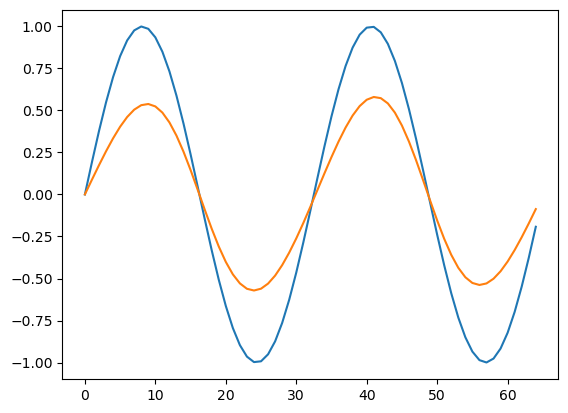

/global/homes/h/hbhat512/.conda/envs/myenv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


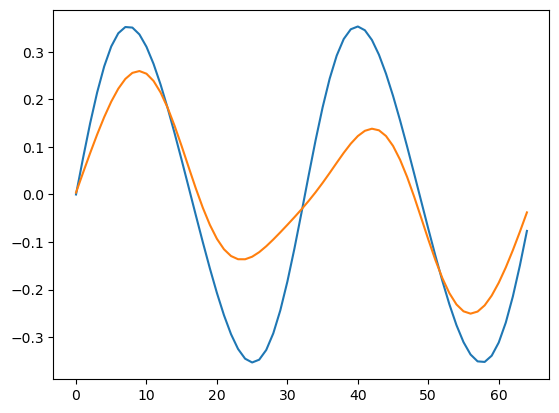

In [48]:
plt.plot(truef1[:,n2])
plt.plot(lf1[:,n2])
plt.show()
plt.plot(truef2[n2,:])
plt.plot(lf2[n2,:])
plt.show()

In [49]:
learnedtheta

array([[[-1.74673835e-05-2.15183921e-05j,
          2.79138601e-05+7.60080431e-05j],
        [ 1.61570591e-05-3.87376889e-05j,
          1.33231797e-05+8.55086885e-06j],
        [-3.23098185e-05-4.61223620e-05j,
          2.18977955e-05-4.01425595e-05j],
        [-1.09425929e-05+1.45417636e-05j,
         -1.45448413e-05-1.38405729e-04j],
        [-4.39675626e-05+3.01988649e-04j,
         -5.89726816e-05-3.33109350e-03j],
        [ 3.15468692e-06-5.49755274e-05j,
          3.07122430e-05-1.79346178e-04j],
        [-6.42668482e-06+2.97991258e-03j,
          2.14753071e-05-1.46350075e-05j],
        [-1.29934096e-05+6.08719161e-03j,
         -2.76339197e-05-3.46261691e-03j],
        [-1.54286513e-05+6.50154966e-03j,
          1.37306106e-05-2.77860430e-03j]],

       [[ 9.93596939e-06-3.70002323e-05j,
          1.97760502e-05+3.33662666e-05j],
        [-1.07398617e-04-2.22152811e-04j,
         -3.01116480e-05-9.15652475e-06j],
        [ 9.63069703e-05-3.23844234e-03j,
          4.97290631e